<img src="./img/HWNI_logo.svg"/>

# Lab 09 - Fitting Models

In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import scipy.stats

# choose colors that work for most color-blind folks
sns.set_palette("colorblind")
sns.set(color_codes=True)

import util.lab09utils as utils

from ipywidgets import interact,interactive, fixed, interact_manual

utils.formatDataframes()

## Maximum Likelihood Model Fitting

In the last lab, we examined a variety of model families. We also used the models to generate data. In science, we usually go the other way around: we collect data and then try to fit a model to it. 

In one sense, this is a hopeless endeavor. For any dataset, the chance that a given model would generate it is almost always non-zero. For example, a linear model could appear quadratic, or a quadratic model linear, if the random components lined up just right.

So simply asking that the model predicts we'd see the data points that we saw isn't quite enough. Instead, we ask that our model assigns a *high probability* to seeing the data that we saw. Once we've picked a model family (e.g. linear model, linearized/nonlinear model with fixed non-linearities), we can use this as a criterion to pick a particular model out as best: we want the model that assigns the *highest* probability to our data.

$$
\text{best model} = \arg\!\text{max}_{\text{model family}}\ p(\text{dataset}\lvert\text{model})
$$

Where $\arg\!\text{max}$ is math-speak for the "$\text{arg}$ument that $\max$imizes this function" and $_{\text{model family}}$ is pronounced "over the model family", aka "only consider models from this family". So we read the above equation as "the best model in the model family is the one that maximizes the probability of the data".

We frame our problem in this way because that makes it an *optimization problem* -- a problem where, given a function that tells us how "good" something is, we have to find the best choice out of a set of options. Optimization is a general principle of mathematics and science -- many mathematical quantities can be defined as "optimal choices" for some problem (including the gradient function, which we'll be using to do some of our optimizations!), and the sciences have made great strides based on the assumption that biological systems evolve to find optimal solutions to problems or that physical systems move to minimize their energy.

Let's dig into the function, $p(\text{dataset}\lvert\text{model})$, that we're trying to optimize.

### Likelihoods

As a reminder, $p(x \lvert y)$ means "the probability of $x$, *given* that we know $y$". When we pick a fixed $y$ and change the variable $x$, we call this function a *conditional probability*, since it talks about the probabilities of events $x$ under the *condition* that $y$ is true. When we picked a fixed $x$ and vary $y$, it is traditional to call this the *likelihood function*.

Therefore, this method of fitting models is called *maximum likelihood fitting*, since we fit the model by maximizing the likelihood. In this class, we'll focus on maximum likelihood methods, though we note in passing that other methods exist.

Usually, we assume that our observations are *independent*, which means that the probability of a group of observations is the product of the probability of observing each individually. This lets us write

$$
\text{best model} = \arg\!\text{max}_{\text{model family}}\ p(\text{dataset}\lvert\text{model})
$$

as

$$
\text{best model} = \arg\!\text{max}_{\text{model family}} 
p(\text{datapoint 1}\lvert\text{model})* p(\text{datapoint 2}\lvert\text{model})* ...
* p(\text{datapoint N}\lvert\text{model})
$$

Just as mathematicians invented the symbol $\Sigma$ to stand in for "add all of these things together", they invented a symbol to stand for "multiply all of these things together: $\Pi$, or "capital $\pi$". Why $\pi$? The letter $\pi$ is the Greek letter corresponding to the Latin $p$. This $p$ stands for *product*, since we're multiplying, or computing the *product* of, all of the variables.

This lets us write our equation even more simply:

$$
\text{best model} = \arg\!\text{max}_{\text{model family}}\ \prod_{\text{dataset}} p(\text{datapoint}\lvert\text{model})
$$

where $_{\text{dataset}}$ indicates that we're taking the product over the dataset.

### Negative Log-Likelihoods

It is customary at this point to do two things: first, we note that the argument that maximizes a thing and the argument that maximizes the log of that thing are the same, because logarithms don't change the order of numbers. The same argument would apply to, e.g., multiplying all the values by the same number or adding the same number to each value. This lets us write:

$$
\text{best model} = \arg\!\text{max}_{\text{model family}}\ \log \prod_{\text{dataset}}  p(\text{datapoint}\lvert\text{model})
$$

The purpose of logarithms is to turn products of things into sums of things, so we can rewrite the above into:

$$
\text{best model} = \arg\!\text{min}_{\text{model family}}\ \sum_{\text{dataset}} \log p(\text{datapoint}\lvert\text{model})
$$

Then, we note that maximizing a thing is the same as minimizing negative one times that thing. This lets us write:

$$
\text{best model} = \arg\!\text{min}_{\text{model family}}\ \sum_{\text{dataset}} -\log p(\text{datapoint}\lvert\text{model})
$$

where $\arg\!\text{min}$ means $\text{min}$imize instead of $\text{max}$imize. Because this function is minus one times the logarithm of the likelihood function, we call it the "negative log-likelihood". 

Why do we do this? One explanation usually given is that "it makes the algebra easier". Sums are more familiar than products, after all! Some expositors also note that, on a computer, multiplying lots of small numbers is prone to error, and logarithms mitigate that issue. Another common argument is that, for most optimization problems, we think of "minimizing a cost" rather than "maximizing a reward" -- finding the shortest distance between two points, reducing expenditures for a business, spending the least energy -- and we want to connect our problem as closely as possible to other optimization problems, so that we can make as much use as possible of other work.

I find these explanations to be a little lame. There's a deep reason why we perform this series of transformations.

The negative log probability is also called the *surprise*, and it shows up in fields like information theory and statistical physics, where it's connected to *entropy*, *information*, and *energy*. In this view, by taking the negative log, we've re-written our problem from "maximize the likelihood" into "minimize the total surprise", which is an equivalent, but more natural, way of thinking about the problem of model fitting.

It's a bit outside the scope of this class, but if you're interested, check out [this blog post](http://charlesfrye.github.io/stats/2016/03/29/info-theory-surprise-entropy.html) for more!

### Putting It All Together

Recall that we defined our models by combining:

$$
\hat{y} = f(x,\theta) \\
\epsilon \sim p(\epsilon)\\
y = \hat{y} + \epsilon
$$

where $x$ is the variable we are using to predict $y$ using a modeling function $f$ with parameters $\theta$. The function $f$ captures the deterministic part of the relationship between $x$ and $y$. The random part of this relationship is in the variable $\epsilon$, called the "noise" when we think about generating data and called the "error" or the "residual" when we think about fitting a model.

In order to connect this idea with the above discussion, we need to write out the surprise associated with observing a datapoint given a model.

$$
\begin{align}
    -\log p(\text{datapoint}\lvert\text{model}) &= -\log p(x,y\lvert\theta) \\
        &= -\log p(y\lvert x,\theta) - \log p(x\lvert\theta)
\end{align}
$$

Where we've used the equation relating conditional probability and joint probability: $p(y,x \lvert \theta) = p(y\lvert x,\theta) p(x\lvert \theta)$. Usually, we assume that all of our datapoints are equally likely, so $\log p(x\lvert\theta)$ is just a constant that we can ignore.

We can simplify the other term by remembering the relationship between $y$ and $x$ is captured by the model $\theta$ and the residual $\epsilon$:

$$
\begin{align}
    -\log p(y\lvert x,\theta) &= -\log p(y\lvert \hat{y}) \\
        &= -\log p(\epsilon)
\end{align}
$$

We can put this into our equation above to get the following:

$$
\text{best model} = \arg\!\text{min}_{\text{model family}}\ \sum_\text{dataset} -\log p(\text{residual})
$$

We can read this in English as "the best model from a family is the model that is least surprised by its errors". Since most models we propose say that big errors are less likely than small errors, we recover the intuitive idea that a better model has less error, but now we we can quantify how much and what kind of error is acceptable.

To connect this idea to more general problems in optimization, we can think of $-\log p(\epsilon)$ as a function of the parameters, $\theta$. In this form, we call it the *cost function* ($C$ for short) for our optimization problem. It's almost as though the models in the family are businesses, competing to see who can model the data with the lowest cost (least surprising errors) and the winner is the best model.

$$
\text{best model} = \arg\!\text{min}_{\text{model family}}\ \sum_\text{dataset} C(\text{datapoint},\theta)
$$

### Important Special Case: Gaussian Errors

For many models, we make the following assumptions about our errors: they are equally likely to occur in either direction, bigger errors are less likely than small errors, and there is a characteristic scale to those errors. If we combine these assumption together, the appropriate distribution for modeling our errors is the Gaussian distribution, as we discussed earlier in the course.

The probability density function for a Gaussian is

$$
p(x\lvert \mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}\mathrm{e}^{-\frac{(x-\mu)^2}{2\sigma^2}}
$$

where $\mu$ is the mean and $\sigma$ is the standard deviation. This is a somewhat intimidating-looking equation. Let's look at the surprise, the negative log probability, instead:

$$
-\log p(x\lvert \mu,\sigma) = (x-\mu)^2 - 2\log{2\sigma} - \log{\sqrt{2\pi}\sigma}
$$

That's an improvement! In many cases, our models don't try to predict $\sigma$, so all of the terms that don't involve $x$ or $\mu$ will be constant across the model family. We can roll these terms into a single constant, $A$:

$$
-\log p(x\lvert \mu,\sigma) = (x-\mu)^2 - A(\sigma)
$$

That's more like it! What this says is that it's more suprising to find $x$ further from the mean $\mu$, with the exact amount of surprise determined by the standard deviation.

To plug this into the "best model" equation above, we need to remember that the value of $\epsilon$ is $y-\hat{y}$ and the mean is $0$, so we get:

$$
\begin{align}
    \text{best model} &= \arg\!\text{min}_{\text{model family}}\ \sum_\text{dataset} -\log p(\epsilon) \\
        & = \arg\!\text{min}_{\text{model family}}\ \sum_\text{dataset} (\epsilon-0)^2 - A(\sigma) \\
        &= \arg\!\text{min}_{\text{model family}}\ \sum_\text{dataset} (y-\hat{y})^2 \\
\end{align}
$$

Almost done! We can make the final equation more explicit by recognizing two things: first, the different elements of the model family usually correspond to different values of the parameters $\theta$, so we can replace our implicit optimization over the family with an explicit optimization over $\theta$. We can also substitute in the definition of $\hat{y}$, and we'll have a usable formula for fitting models with Gaussian error.

$$
      \text{best model} = \arg\!\text{min}_{\theta}\ \sum_\text{dataset} \left(y-f(x,\theta)\right)^2 \\
$$

This formula tells us that we should adjust $\theta$ to reduce the sum of squared errors. Because of this, we call the fitting process for models with Gaussian errors "least-squares fitting". In terms of the "cost function" view above, we are applying a *quadratic*, or squared, cost to the errors.

## Even Specialer Case: Gaussian Errors, Linear Models

In the case of linear models with independent, equal-variance Gaussian noise, we get the following expression:

$$
      \text{best model} = \arg\!\text{min}_{\theta}\ \sum_\text{dataset} \left(y-w^T x\right)^2 \\
$$

Note that we've replaced $\theta$ with $w$ here to match the traditional notation in linear modeling. We can apply a square root outside the equation, just like we did with the logarithm before, because square roots also don't change the ordering of numbers. This gives us:

$$
      \text{best model} = \arg\!\text{min}_{\theta}\  \sqrt{\sum_\text{dataset}\left(y-w^T x\right)^2} \\
$$

The square root of the sum of squares is also called the *Euclidean distance*. It's the same distance we use in our everyday lives to compute lengths and areas and volumes!

This gives us an appealing geometric view for how to perform maximum likelihood fitting in this case. It's easiest to picture it in the case of three datapoints and two regressors, since we're best at picturing three dimensions, rather than four or one hundred.

First, we note that in this case, $w^Tx$ defines a plane, a flat 2-D region in 3-D space. That is, as we vary the parameters $w$, we trace out a plane in 3-D space, where the value in each dimension is given by the predicted value $\hat{y}$. The true values $y$ also live in 3-D space. The best model, then, has the parameters $w$ that minimize the distance from $y$ to $w^Tx$.

The cell below will visualize this geometric relationship. The data values, $y$, are plotted as a blue circle. The achievable predictions from the linear model, $w^Tx$, appear as a pink sheet. The predictions of a particular model are plotted as a star. If the `bestfitModel` argument is `True`, this model will be the best-fit linear model. If it is not, then the model will be chosen randomly. The residuals, which are the differences between the data values and the predictions, appear as a red line.

The plot is interactive. Use the left mouse button to rotate the axes and the right mouse button to zoom in and out (you'll want to use an old-fashioned mouse, rather than a touchpad).

<IPython.core.display.Javascript object>


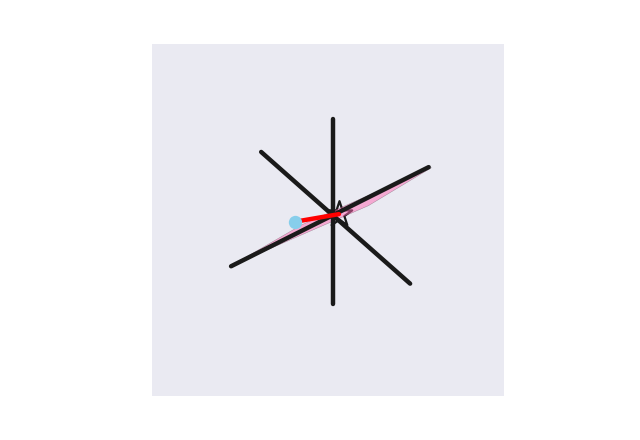

In [12]:
fitBestModel = False
utils.makeRegressionPlot(fitBestModel)

Much like an optical illusion, it can be difficult to see the 3-D until you "trick your brain" into seeing it. Try rotating so that you are looking parallel to the model plane and then wiggling the plot. The apparent motion, or parallax, will help. Lastly, matplotlib's 3D function is limited in its ability to represent occlusion, so the residual line will always appear to be occluding the model plane.

If the data values and predictions are too close to each other, either zoom in or re-run the cell above to get a different dataset and model. If you zoom in too far, the plot will start breaking down, so if you notice any weirdness, just re-run the cell. This is more common when using the `bestFitModel`.

#### Q1 Compare and contrast the relationships between the residuals, the data values, and the model predictions with `bestFitModel` equal to `True` and `False`. What's different geometrically, i.e. in terms of angles and distances?

The cleanest way to recast the geometric relationship between the best-fit model and the residuals from geometric terms to statistical terms is to say that when we have the best-fit linear model, the *correlation between the residuals and the regressors is 0*.

#### Q2 Connect this observation to the geometric picture above.

We can use this to directly compute the best-fit model for any model that is linear in its parameters, i.e., for a linear or a linearized model.

The statement that the correlation between the residuals and the regressors is 0 for the best-fit model looks like this:

$$
(y-w^TX)X^T = 0
$$

where $X$ is the data matrix, $y$ is the dataset, and $\hat{w}$ is the weight vector of the best-fit model.
A quick series of algebraic manipulations gets us a usable expression: we distribute $X^T$ over the subtraction in the parentheses, move $w$ and friends over to the right hand side, and then right-multiply by the inverse of $XX^T$. This last step is just algebraic cancellation, as when we right-multiply $ab=c$ by the inverse of $b$, $b^{-1}=\frac{1}{b}$, to get $a=c*b^{-1}=\frac{c}{b}$.

$$
(y-\hat{w}^TX)X^T = 0 \\
yX^T - \hat{w}^TXX^T = 0 \\
\hat{w} = yX^T(XX^T)^{-1} 
$$


This final version of the formula is relatively less important than the intuition that we used to get the original equation. The code below will develop this intuition some more by running the following experiment: first we pick a ground-truth linear model. Then, we generate multiple datasets from that model. For each model, we compute the best-fit parameters using the equation above, and then compute the correlation between the residuals and the regressors.

The resulting correlations are plotted as a histogram, beneath an example dataset and a histogram of residuals from that dataset.

The code below will simulate experiments where we fit a linear model to data. In a single experiment, we: specify a linear model, generate data from it, fit parameters to the data, and then compute the correlation between the residuals and the regressors.

A single simulation will perform this experiment multiple times. The resulting distribution is plotted as a histogram. The data and residuals from a single experiment are also plotted.

#### Q3 What do you expect the correlation between the residuals and the regressors to be?

<IPython.core.display.Javascript object>


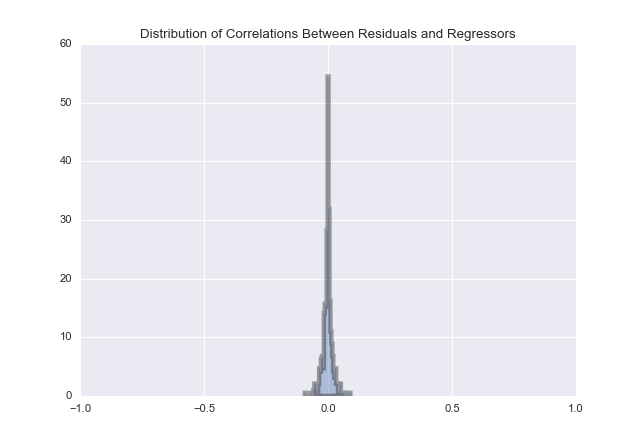

<IPython.core.display.Javascript object>


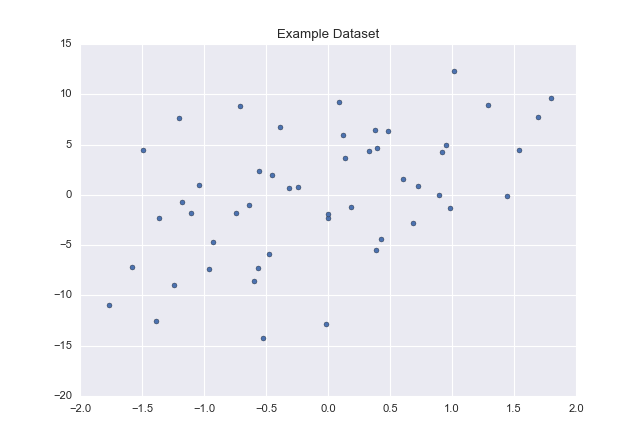

<IPython.core.display.Javascript object>


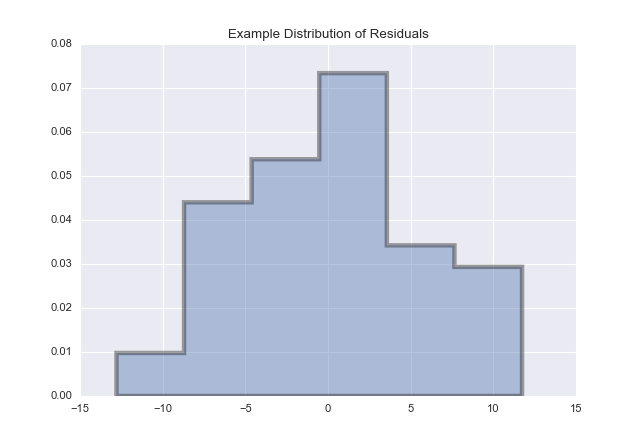

In [3]:
numExperiments = 500
numDatapoints = 50

useGroundTruth = False
gaussianNoise = True
noise_level = 5

results = utils.runSimulation(numExperiments,numDatapoints,
                        useGroundTruth,
                        gaussianNoise,noise_level)

utils.plotSimulationResults(*results)

Observe the distribution of residuals for one dataset.

#### Q4 What does our model assume about this distribution? Are our assumptions correct here?

Check out the distribution of values for the correlations.

The value won't always be exactly what you expected because of numerical errors in the computation. These errors actually get bigger when the data is less random or when a pair of regressors is highly correlated ($r^2>0.99$).

To see this, decrease the `noise_level` to `10e-15`.

#### Q5 What happens to the distribution of the correlations?

A professional implementation of ordinary least squares fitting will usually avoid this issue by cleverly rearranging the matrix equation for computing the weights.

Return the `noise_level` to a reasonable value, like `5`, and set the variable `useGroundTruth` to `True`. 

When `useGroundTruth` is true, instead of fitting a linear model to the data, we instead use the same parameters that were used to generate the data as the parameters in our model. 

#### Q6 What would you expect the distribution of correlations to look like now? Where will its center be? What will the spread look like? 

Run the simulation with `useGroundTruth` set to `True`. 

#### Q7 Were your predictions correct?

Still using the ground truth parameters, increase the number of datapoints by a factor of 10, then run again. Do this twice.

#### Q8 What happens to the distribution of the correlations? Can you explain why?

Set the argument `gaussianNoise` to `False` and run again.

#### Q9 What is the distribution of the residuals? Why might this be a bad thing for our model?

Compare runs with Gaussian and non-Gaussian noise, both without using the ground-truth value.

#### Q10 What happens to the distribution of correlations? What about the residuals?

#### Challenge Q: How would you solve the problem that the noise is non-Gaussian? Assume that you know the distribution.

## Fitting Nonlinear Models

With nonlinear models, the collection of all models in the family no longer defines a plane. Instead, we end up with a curved surface. This means we can't write down an explicit formula and solve for the correct parameters.

Let's look again at the equation that expresses the cost-function view of our problem.

$$
      \text{best model} = \arg\!\text{min}_{\theta}\ \sum_\text{dataset} C(\text{datapoint},\theta) \\
$$

Our goal is to adjust theta to make the cost function as small as possible. For most cost functions, we can achieve this in one of two ways.

The only approach that is guaranteed to work in all cases is to try absolutely every single value of $\theta$. If we've evaluated all of the models, then we certainly know which one is best! Unfortunately, this assurance is about as valuable as a ticket on a rocketship to Alpha Centauri: you'll be dead before the journey's over, so what's the point? 

We can usually do a pretty decent job by just trying a random selection of lots of values for $\theta$. The emphasis here is on lots. As an example, this approach is frequently employed as part of the pipeline in machine learning papers by the likes of Amazon, Google, and Facebook, and the cost to simply run enough computers long enough to check all of these values runs into the hundreds of thousands or millions of dollars.

Luckily, there is an alternative that works most of the time! If we know what the derivative of the cost function is, we can follow it towards a (locally) minimum value of the cost function. This is called *gradient descent*.

That is, we evaluate the derivative of the cost function at the current value of $\theta$. If $\theta$ is a vector, then the derivative is a vector that contains the derivative of the cost function with respect to each element of $\theta$. We call this the *gradient*. The gradient vector points in the direction which makes the cost function go up the most, also known as the *direction of steepest ascent*, which is the opposite of the direction which makes the cost function go down the most, the *direction of steepest descent*. So to make the cost function go down as fast as possible, we multiply the gradient vector by -1 (flipping it around) and take a small step in that direction.

This is all a lot easier to understand when you a) visualize the cost surfaces and b) try fitting parameters yourself.

### Visualizing Gradient Descent with Cost Surfaces

The code in the box below will generate a plot of a *cost surface*. 

To draw a cost surface, we plot the value of the cost function at each combination of values for the inputs. Because we're able to, at most, make things in 3 dimensions, we'll have two input dimensions and leave the third for the cost.

This may seem somewhat mysterious, but it's actually quite straightforward. 

First, the notion of a surface is one way to generalize the familiar old idea of the graph of a function to functions that take more than one input. Read the paragraph above again, but imagine a cost function having only one input dimension. It's describing how to draw the graph of the cost function!

Second, we live on a surface of this type, the surface of the Earth. If you want to think of it as a cost function, you could think of it as the cost function you'd have if you didn't like being at a high altittude.

Let's visualize some surfaces that are closer to what you might see if you plotted the cost surface for a model you were optimizing. A list of cost functions is defined in the cell below. The cell beneath it will visualize the cost function that is assigned to the variable `cost`. The value of the cost function is indicated with both z-value and color. Darker color indicates a higher cost.

The following questions will ask you to visualize these cost surfaces and answer questions about them. The plots are interactive. Again, this means you can pan with the left mouse button and zoom with the right.

In [4]:
# this is a list of cost functions.
#  they are defined in-line and have no name, so they are called
#  anonymous or in-line functions.
#  they are also called "lambda functions" for historical reasons.

scale = 1

costs = [lambda x,y: np.square(x)+np.square(y),
            lambda x,y: np.square(x)+0.1*np.square(y),
            lambda x,y: 3*np.square(x)+0.1*np.square(y),
            lambda x,y: np.cos(3*x)+0.5*(np.square(x)+np.square(y)+x),
            lambda x,y: np.cos(3*x)+np.square(x)+np.square(y),
            lambda x,y: np.where(np.abs(x)+np.abs(y)<0.75,0,np.abs(x)+np.abs(y)-0.75),
            lambda x,y: np.where(x>y+0.25,1.25,y)+np.square(x)+np.square(y),
            lambda x,y: 0.1*np.random.standard_normal(size=x.shape),
            lambda x,y: utils.gaussRandomField(x,y,scale)]

<IPython.core.display.Javascript object>


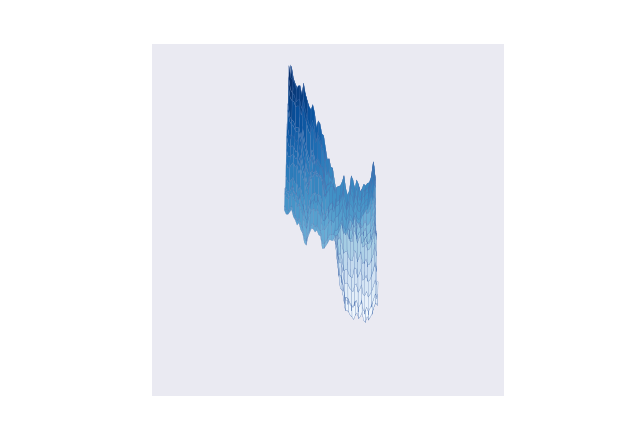

In [5]:
cost = costs[8]

N = 50
meshExtent = 1.5

utils.plotCostSurface(cost,N,meshExtent)

For certain problems, gradient descent performs nicely. View `costs[0]`.

#### Q11 Pick a few different starting points and follow the direction of steepest descent. Where do you end up?

#### Q12 What's nice about this cost surface?
*This question might be easier to answer once you've seen some of the other cost surfaces.*

When we follow gradients numerically, using a computer, we have to pick a scale for the "size" of steps we take. This can cause problems we might not anticipate with an intuitive view of the gradient. View `costs[1]` and then `costs[2]`.

#### Q13 Why might picking a size of step cause issues with the `costs[1]` or `costs[2]` surfaces?

Other problems can't be solved by gradient descent directly. Select `costs[3]`.

#### Q14 Again, select multiple different starting points and follow the direction of steepest descent. What's different in this case?

#### Q15 If this were the cost function of a model, why might this change in the behavior of gradient descent be a bad thing?

There are several similar cases to the above issue that are of interest. View `costs[4]` and then `costs[5]`.

#### Q16 Compare and contrast the three cost surfaces. Which ones cause issues for modelers? Explain your answers.

Some issues are more theoretical than practical. View `costs[6]`.

#### Q17 Can we still do gradient descent on this cost surface? Why or why not?

For some cost functions, the right method of minimization can be hard to decide. View `costs[7]`.

#### Q18 What strategies might you use to minimize this cost function?

The error surfaces for things like "a neural network that maps [pictures of horses to almost identical pictures of zebras](https://github.com/junyanz/CycleGAN)" are expected to be much more complicated than the ones we've looked at so far.

View `costs[8]`. This one is different each time, so I'd suggest running the cell multiple times.

You can also attempt the following: set the parameters `N = 100` and `meshExtent = 10` in the plotting cell (original values are `50` and `1.5`, for reference) and set the parameter `scale = 1` in the cell that defines the `costs` (original value `0.1`). With these settings, the plot will take a bit of time to render on most machines and the plot will lag when interacted with. On some machines, this may consume too much memory and cause the plot to not render. If the plot successfully renders and you'd like to see more, increase the parameters to `N=150` and `meshExtent = 25`.

#### Q19 Do these cost surfaces look like promising candidates for gradient descent? Why or why not?

### Fitting Models by Hand

You can get a better intuitive feel for model fitting by setting the parameters yourself!

The following two cells will

1. Set up a plot for a family of linear models, as in the last problem set, and then add some data generated from a model with slope parameter `w` and bias parameter `b`.
1. Make the plot interactive, so you can adjust the slope and bias parameters.

First, attempt to fit the data by eye.

<IPython.core.display.Javascript object>


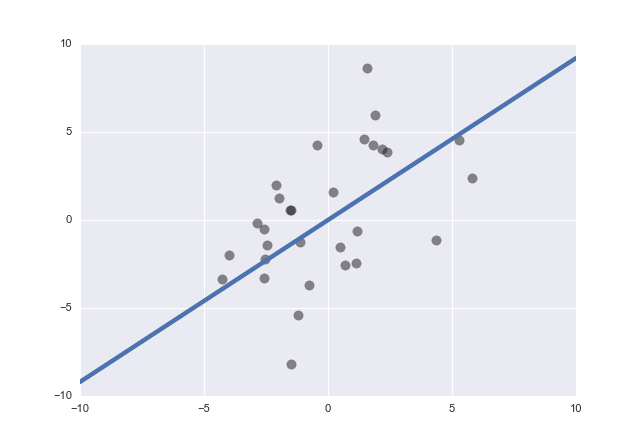

In [6]:
numDatapoints = 2500
inputValues = np.linspace(-10,10,numDatapoints)

parameters = utils.makeLinearParameters()

LM = utils.LinearModel(inputValues,parameters)

LM.plot()

N = 30

w = 0.6
b = 0.5
noise_level = 3

xs = np.random.standard_normal(N)*2.5

ys = [w*x + b + np.random.standard_normal()*noise_level for x in xs]

LM.setData(xs,ys)

In [7]:
LM.makeInteractive()

MSE:	10.0679688983


Once you've found a fit you like, run the cell below this one. This will now cause the model to print the mean squared error as you change the parameters.

In [8]:
LM.showMSE = True

#### Q20 Wiggle the parameters around a bit (you can do this more finely by clicking one of the sliders and then using the arrow keys). Do the parameters you chose minimize the MSE cost? How can you tell?

#### Q21 Find the MSE-minimizing model. Describe the strategies you use below.

The cell below will let you do the same for two different nonlinear models. First, run the cell as is and fit the data by hand. Then, comment out the first two lines, which set up a rectified linear model, and uncomment the following two lines, which set up a trigonometric model.

<IPython.core.display.Javascript object>


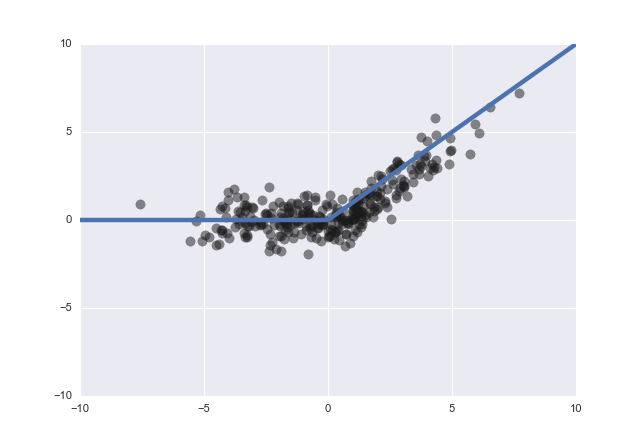

In [9]:
thetaRange = [-10,10]
inputValues,parameters,transform = utils.setupRectLin(thetaRange=thetaRange)

# thetaRange = [-5,5]
# inputValues,parameters,transform = utils.setupTrig(np.sin,thetaRange=thetaRange)

NLPM = utils.NonlinearModel(inputValues,parameters,transform)

N = 300

theta = 0.75
noise_level = 0.75

xs = np.random.standard_normal(N)*2.5

ys = transform(theta,xs)+np.random.standard_normal(N)*noise_level

NLPM.plot()
NLPM.showMSE = True
NLPM.setData(xs,ys)

In [10]:
NLPM.makeInteractive()

MSE:	0.762847580198


#### Q22 Compare and contrast your strategies for the two different nonlinear models. Was either close to gradient descent? What might happen if you used gradient descent on each model?

For your convenience, the code cell below will plot the error as a function of `theta` for the model you most recently ran above.

<IPython.core.display.Javascript object>


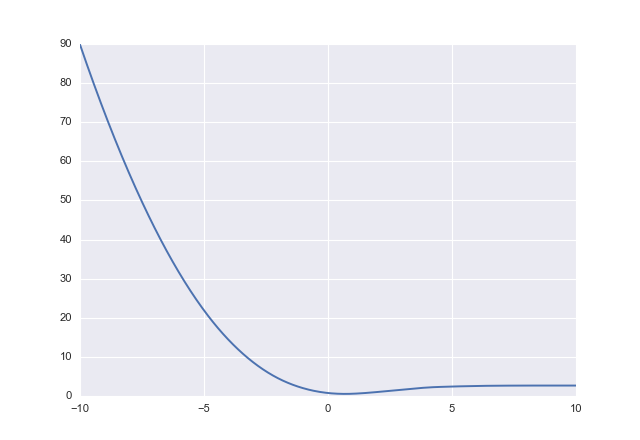

In [11]:
plt.figure()
thetas = np.linspace(*thetaRange,num=500)
plt.plot(thetas,[np.mean(np.square(ys-transform(theta,xs))) for theta in thetas]);